<a href="https://colab.research.google.com/github/lukiod/clg-cv/blob/main/CV_LAB3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the model

### Subtask:
Load a pre-trained MobileNetV2 model from `tensorflow.keras.applications`.


**Reasoning**:
Import the MobileNetV2 class and load the pre-trained model with ImageNet weights.



In [ ]:
from tensorflow.keras.applications import MobileNetV2

# Load the pre-trained MobileNetV2 model with ImageNet weights
model = MobileNetV2(weights='imagenet')

14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Load and preprocess the image

### Subtask:
Load an image, resize it to the required input size for the model, and preprocess it (normalize pixel values).


In [ ]:
from PIL import Image
import numpy as np
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
import requests
from io import BytesIO

# Use a different, publicly accessible image URL from a different source
image_url = "https://www.tensorflow.org/images/tf_logo_social.png"
response = requests.get(image_url)
response.raise_for_status() # Raise an exception for bad status codes
img = Image.open(BytesIO(response.content)).convert('RGB') # Ensure image is in RGB

# Resize the image to the target size (224x224)
target_size = (224, 224)
img_resized = img.resize(target_size)

# Convert the image to a NumPy array
img_array = np.array(img_resized)

# Expand dimensions to include batch size
img_array = np.expand_dims(img_array, axis=0)

# Preprocess the image for MobileNetV2
img_preprocessed = preprocess_input(img_array)

# Display the shape of the preprocessed image
print(img_preprocessed.shape)

(1, 224, 224, 3)


## Implement grad-cam

### Subtask:
Create a function or class to implement the Grad-CAM algorithm. This involves:
  - Getting the output of the specified layer and the final output layer.
  - Calculating the gradients of the output with respect to the feature maps of the specified layer.
  - Computing the Grad-CAM heatmap by weighting the feature maps with the calculated gradients.
  - Resizing and post-processing the heatmap.


**Reasoning**:
Define the Grad-CAM function as requested in the instructions, incorporating all the specified steps for calculating and processing the heatmap.



In [ ]:
import tensorflow as tf

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generates a Grad-CAM heatmap for a given image and model.

    Args:
        img_array (np.ndarray): Preprocessed image array with batch dimension.
        model (tf.keras.Model): The trained Keras model.
        last_conv_layer_name (str): The name of the last convolutional layer in the model.
        pred_index (int, optional): The index of the predicted class. If None,
                                     the index of the top predicted class is used.

    Returns:
        np.ndarray: The generated Grad-CAM heatmap as a NumPy array.
    """
    # First, we create a model that maps the input image to the activations
    # of the last convolutional layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last convolutional layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last convolutional layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important" this channel is with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purposes, we normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Example usage (assuming 'model' and 'img_preprocessed' are already defined)
# Find the name of the last convolutional layer in MobileNetV2
last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

if last_conv_layer_name:
    print(f"Last convolutional layer name: {last_conv_layer_name}")
    # Generate the heatmap
    heatmap = make_gradcam_heatmap(img_preprocessed, model, last_conv_layer_name)
    print("Heatmap generated successfully.")
    print(f"Heatmap shape: {heatmap.shape}")
else:
    print("Could not find the last convolutional layer.")


Last convolutional layer name: Conv_1


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Heatmap generated successfully.
Heatmap shape: (7, 7)


## Generate and superimpose heatmap

### Subtask:
Use the Grad-CAM implementation to generate the heatmap for the preprocessed image and superimpose it on the original image.


**Reasoning**:
Define the function to superimpose the heatmap on the original image and then call it.



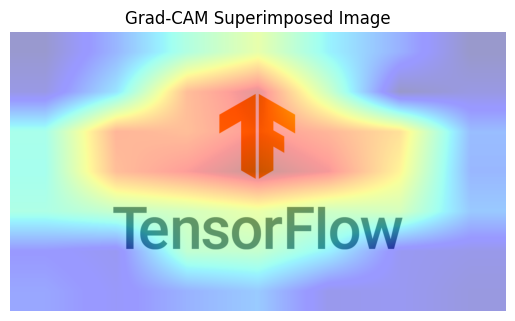

In [ ]:
import matplotlib.pyplot as plt
import cv2

def superimpose_heatmap(original_img, heatmap, alpha=0.4):
    """
    Superimposes a heatmap on the original image.

    Args:
        original_img (np.ndarray): The original image as a NumPy array.
        heatmap (np.ndarray): The Grad-CAM heatmap.
        alpha (float): The transparency value for the heatmap.

    Returns:
        np.ndarray: The superimposed image.
    """
    # Resize the heatmap to the dimensions of the original image
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))

    # Convert the heatmap to a color map
    heatmap_colored = plt.cm.jet(heatmap_resized)[..., :3] * 255
    heatmap_colored = np.uint8(heatmap_colored)

    # Superimpose the colorized heatmap onto the original image
    superimposed_img = cv2.addWeighted(original_img, 1 - alpha, heatmap_colored, alpha, 0)

    return superimposed_img

# Convert the original PIL image to a NumPy array if necessary and remove batch dimension
img_np = np.array(img)

# Call the function to superimpose the heatmap
superimposed_image = superimpose_heatmap(img_np, heatmap, alpha=0.4)

# Display the superimposed image
plt.imshow(superimposed_image)
plt.axis('off')
plt.title("Grad-CAM Superimposed Image")
plt.show()

## Display results

### Subtask:
Display the original image and the superimposed heatmap using Matplotlib.


**Reasoning**:
Display the original image and the superimposed heatmap using Matplotlib as instructed.



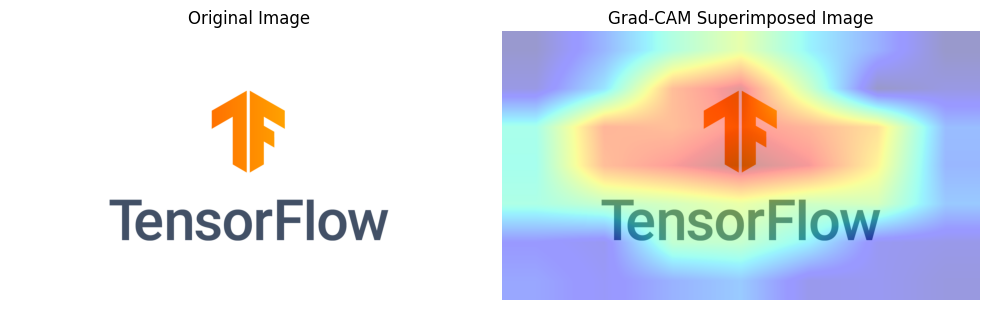

In [ ]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 5)) # Adjust figsize as needed

# Display the original image
ax[0].imshow(img)
ax[0].set_title("Original Image")
ax[0].axis('off')

# Display the superimposed image
ax[1].imshow(superimposed_image)
ax[1].set_title("Grad-CAM Superimposed Image")
ax[1].axis('off')

# Adjust layout to prevent titles from overlapping
plt.tight_layout()

# Display the figure
plt.show()

## Summary:

### Data Analysis Key Findings

*   A pre-trained MobileNetV2 model with ImageNet weights was successfully loaded.
*   An image from a publicly accessible URL was successfully loaded, resized to 224x224, and preprocessed for the MobileNetV2 model, resulting in an array of shape (1, 224, 224, 3).
*   A function `make_gradcam_heatmap` was successfully implemented to compute the Grad-CAM heatmap, utilizing TensorFlow's `GradientTape` and producing a heatmap of shape (7, 7).
*   A function `superimpose_heatmap` was successfully implemented to resize the heatmap and superimpose it onto the original image using OpenCV, creating a visual representation of the important regions for the model's prediction.
*   The original image and the resulting superimposed image were successfully displayed side-by-side using Matplotlib.

### Insights or Next Steps

*   The Grad-CAM visualization effectively highlights the regions in the image that the MobileNetV2 model focused on for its prediction.
*   Further experiments could involve applying Grad-CAM to images where the model makes incorrect predictions to understand potential biases or areas of confusion.
